In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/Emotions.csv
/kaggle/input/virtues/Virtues.csv


**Importing the Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

**Loading the Dataset**

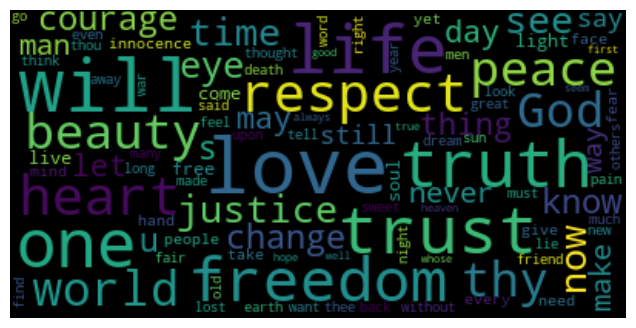

In [3]:
# Reading the text data file
data = pd.read_csv("/kaggle/input/virtues/Virtues.csv")

text_data = ""
for index, row in data.iterrows():
    text_data = text_data + row['text']

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text_data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()


**Creating the Corpus**

In [5]:
# Generating the corpus by
# splitting the text into lines
corpus = text_data.lower().split("\n")
print(corpus[:10], len(corpus))
corpus = corpus[::3]
print(corpus[:10], len(corpus))

['looking over the fields towards the sun,', 'observing that the rain had just begun,', 'a freshness seemed to permeate the air,', 'and all that one could do was, stand and stare,', 'as something magical crept across the skies,', 'a vision that was reflected in my eyes.', 'a sight of infinite beauty, there to see,', 'one of the wonders given to us, for free.', 'lovely colours blending, like a dream,', 'in subtle hues, an arched rainbow supreme.'] 22882
['looking over the fields towards the sun,', 'and all that one could do was, stand and stare,', 'a sight of infinite beauty, there to see,', 'in subtle hues, an arched rainbow supreme.', 'it wounds us as we sing.', 'it rides up in a song.', 'assembling to depart.it is not beauty i demand,', "nor mermaid's yellow pride of hair.", 'your breasts where cupid trembling lies,', "like hebe's in her ruddiest hours,"] 7628


**Fitting the Tokenizer**

In [6]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

print(len(corpus))

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)

7628
Total Words: 8673


**Generating Embeddings**

In [7]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

**Building an LSTM Model**

In [8]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 100)          867400    
                                                                 
 bidirectional (Bidirectiona  (None, 116, 300)         301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 116, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 8673)              875973    
                                                                 
 dense_1 (Dense)             (None, 8674)              75238276  
                                                        

**Training the Model**

In [9]:
history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
1359/1359 [==============================] - 85s 55ms/step - loss: 7.2938 - accuracy: 0.0454
Epoch 2/50
1359/1359 [==============================] - 61s 45ms/step - loss: 6.9016 - accuracy: 0.0474
Epoch 3/50
1359/1359 [==============================] - 60s 44ms/step - loss: 6.7355 - accuracy: 0.0497
Epoch 4/50
1359/1359 [==============================] - 60s 44ms/step - loss: 6.6164 - accuracy: 0.0546
Epoch 5/50
1359/1359 [==============================] - 60s 44ms/step - loss: 6.5148 - accuracy: 0.0607
Epoch 6/50
1359/1359 [==============================] - 59s 44ms/step - loss: 6.4129 - accuracy: 0.0688
Epoch 7/50
1359/1359 [==============================] - 59s 44ms/step - loss: 6.3100 - accuracy: 0.0775
Epoch 8/50
1359/1359 [==============================] - 59s 44ms/step - loss: 6.2025 - accuracy: 0.0840
Epoch 9/50
1359/1359 [==============================] - 59s 44ms/step - loss: 6.1067 - accuracy: 0.0910
Epoch 10/50
1359/1359 [==============================] - 59s 44m

**Saving the Model**

In [10]:
from keras.models import load_model
    
model.save('Virtues_Model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model
    
# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [11]:
print(max_sequence_len)

117
